# 1. Loading Data

In [1]:
%matplotlib inline
import geopandas as gpd
import folium
import branca.colormap as cm
import folium.plugins

In [2]:
apartments = gpd.read_file('./Output/apartments.shp')
neighborhoods = gpd.read_file('./Output/neighborhoods.shp')

In [3]:
apartments.head()

,lat,lon,area,rent,condofee,IPTU,bedrooms,Total_Pric,Total_Pr_1,Total_Pr_2,geometry
0,-19.953305,-43.929241,4775,23000,8000,2700,4,31225.00,6.54,7806.25,POINT (612.045 7793.329)
1,-19.953305,-43.929241,758,16000,8000,2650,5,24220.83,31.95,4844.17,POINT (612.045 7793.329)
2,-19.953305,-43.929241,5000,16000,8000,3007,5,24250.58,4.85,4850.12,POINT (612.045 7793.329)
3,-19.953305,-43.929241,4775,16000,7750,2752,5,23979.33,5.02,4795.87,POINT (612.045 7793.329)
4,-19.939045,-43.919928,510,18000,4300,1822,4,22451.83,44.02,5612.96,POINT (613.030 7794.901)


In [4]:
neighborhoods.head()

,ID1,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODD,NM_DISTRIT,CD_GEOCODS,NM_SUBDIST,CD_GEOCODM,NM_MUNICIP,NM_MESO,NM_MICRO,Dist_KM,geometry
0,358777,310620005640064,URBANO,310620005066,Santa Cruz,310620005,BELO HORIZONTE,310620005,NORDESTE,3106200,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,3.227827,"POLYGON ((611.320 7802.011, 611.360 7801.990, ..."
1,358778,310620005640065,URBANO,310620005066,Santa Cruz,310620005,BELO HORIZONTE,310620005,NORDESTE,3106200,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,3.472099,"POLYGON ((611.503 7801.910, 611.501 7801.939, ..."
2,358779,310620005640066,URBANO,310620005069,Ipiranga,310620005,BELO HORIZONTE,310620005,NORDESTE,3106200,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,3.848714,"POLYGON ((612.049 7801.904, 612.109 7801.927, ..."
3,358780,310620005640067,URBANO,310620005069,Ipiranga,310620005,BELO HORIZONTE,310620005,NORDESTE,3106200,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,3.830777,"POLYGON ((611.863 7801.784, 611.931 7801.810, ..."
4,358781,310620005640068,URBANO,310620005069,Ipiranga,310620005,BELO HORIZONTE,310620005,NORDESTE,3106200,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,3.779755,"POLYGON ((611.855 7801.781, 612.018 7801.624, ..."


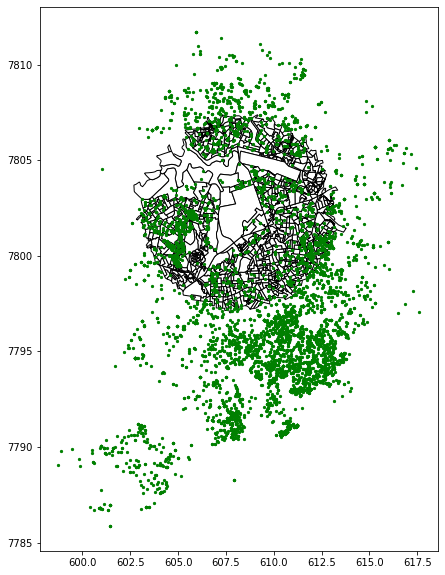

In [5]:
# Loading datas

MAP = neighborhoods.plot(color='white', edgecolor='black', figsize=(15, 10))
apartments.plot(ax = MAP, color='green', markersize = 5)

In [6]:
# Numbers of apartments

apartments.shape

(6433, 11)

In [7]:
# Search only apartments within neighborhoods near UFMG

apartments_UFMG = gpd.sjoin(neighborhoods, apartments, how = 'left', op = 'contains')

apartments_UFMG.shape

(2330, 26)

# 2. Average Price per m2 and Price per Bedrooms

In [8]:
# Changing CRS
apartments_UFMG = apartments_UFMG.to_crs({'init':'epsg:4326'})

# Creating a new dataframe
apartments_UFMG_1 = apartments_UFMG[['NM_BAIRRO', 'geometry', 'Total_Pr_1', 'Total_Pr_2']]
price = apartments_UFMG_1.dissolve(by='NM_BAIRRO', aggfunc = 'mean')

In [9]:
price.reset_index(inplace = True)

In [10]:
price = price.fillna({'Total_Pr_1':0, 'Total_Pr_2':0})

In [11]:
#price= price.set_index('NM_BAIRRO')
price.head()

,NM_BAIRRO,geometry,Total_Pr_1,Total_Pr_2
0,Aarão Reis,"POLYGON ((-43.92777 -19.84755, -43.92774 -19.8...",0.000000,0.000000
1,Aeroporto,"POLYGON ((-43.95607 -19.85649, -43.95662 -19.8...",15.800000,763.601667
2,Alto Caiçaras,"POLYGON ((-43.96943 -19.90090, -43.96979 -19.9...",16.404375,670.208750
3,Alípio de Melo,"POLYGON ((-44.00230 -19.90400, -44.00207 -19.9...",17.200625,604.166875
4,Andiroba,"POLYGON ((-43.92714 -19.86681, -43.92690 -19.8...",0.000000,0.000000


In [12]:
# Sparing neighborhoods that have information
price_not_info = price.query('Total_Pr_1 == 0')

prince_info = price.query('Total_Pr_1 > 0')

In [13]:
# Set index
price_not_info_1 = price_not_info.set_index('NM_BAIRRO')

prince_info_1 = prince_info.set_index('NM_BAIRRO')

In [14]:
# UFMG

ufmg = price_not_info.query("NM_BAIRRO == 'Campos UFMG'")
ufmg.head()

,NM_BAIRRO,geometry,Total_Pr_1,Total_Pr_2
18,Campos UFMG,"POLYGON ((-43.97040 -19.86297, -43.96631 -19.8...",0.0,0.0


# 3. HeatMap

In [15]:
# Centroid


y = price.query("NM_BAIRRO == 'Campos UFMG'").centroid.y.iloc[0]
x = price.query("NM_BAIRRO == 'Campos UFMG'").centroid.x.iloc[0]

In [16]:
linear = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=0, vmax=26
)

from branca.colormap import linear

colormap = linear.YlOrRd_09.scale(0,27)
colormap

In [17]:
linear = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=0, vmax=1500
)
linear

In [18]:
# Creating dict

price_dict = prince_info.set_index('NM_BAIRRO')['Total_Pr_2']

In [19]:
price_dict

NM_BAIRRO
Aeroporto                      763.601667
Alto Caiçaras                  670.208750
Alípio de Melo                 604.166875
Aparecida                      487.217000
Aparecida 7ª Seção             416.151667
                                 ...     
Tiradentes                    1659.720000
Universitário                  553.330000
União                          948.061935
Urca                           416.250000
Vila Suzana Primeira Seção     300.000000
Name: Total_Pr_2, Length: 78, dtype: float64

In [20]:
base = folium.Map([y, x], zoom_start=13, tiles='OpenStreetMap')


folium.Choropleth(
    geo_data=prince_info_1,
    name='choropleth',
    data=prince_info,
    columns=['NM_BAIRRO', 'Total_Pr_1'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='PREÇO / M2'
).add_to(base)



folium.GeoJson(
    price_not_info,
    style_function=lambda feature: {
        'fillColor': 'white',
        'fillOpacity' : 0.8,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(base)
  

folium.GeoJson(
    ufmg,
    style_function=lambda feature: {
        'fillColor': 'dodgerblue',
        'fillOpacity' : 0.7,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(base)


for i in range(price.shape[0]):
    geo = folium.GeoJson(price[i:i+1], name = price['NM_BAIRRO'][i], style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillopacity' : 0,
        'opacity': 0.9})
    
    
    label = '{} - R${}'.format(price['NM_BAIRRO'][i], price['Total_Pr_1'][i].round(2))
    folium.Popup(label).add_to(geo)
    geo.add_to(base)
    

base.save('Price_m2.html')
    
base

In [21]:
base = folium.Map([y, x], zoom_start=13, tiles='OpenStreetMap')




folium.GeoJson(
    prince_info_1,
    style_function=lambda feature: {
        'fillColor': linear(price_dict[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity' : 0.9,
    }
).add_to(base)

folium.GeoJson(
    price_not_info,
    style_function=lambda feature: {
        'fillColor': 'white',
        'fillOpacity' : 0.8,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(base)
  

folium.GeoJson(
    ufmg,
    style_function=lambda feature: {
        'fillColor': 'dodgerblue',
        'fillOpacity' : 0.7,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(base)

    
    
for i in range(price.shape[0]):
    geo = folium.GeoJson(price[i:i+1], name = price['NM_BAIRRO'][i], style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillopacity' : 0,
        'opacity': 0})
    
    
    label = '{} - R${}'.format(price['NM_BAIRRO'][i], price['Total_Pr_2'][i].round(2))
    folium.Popup(label).add_to(geo)
    geo.add_to(base)

    

linear.caption = 'PREÇO / N QUARTOS'
linear.add_to(base)

base.save('Price_Bedrooms.html')

base

In [22]:
m = folium.plugins.DualMap(location=(y, x), tiles='OpenStreetMap', zoom_start=13)


folium.GeoJson(
    prince_info_1,
    style_function=lambda feature: {
        'fillColor': linear(price_dict[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity' : 0.9,
    }
).add_to(m.m1)

folium.GeoJson(
    price_not_info,
    style_function=lambda feature: {
        'fillColor': 'white',
        'fillOpacity' : 0.8,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(m.m1)
  
folium.GeoJson(
    ufmg,
    style_function=lambda feature: {
        'fillColor': 'dodgerblue',
        'fillOpacity' : 0.7,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(m.m1)


for i in range(price.shape[0]):
    geo = folium.GeoJson(price[i:i+1], name = price['NM_BAIRRO'][i], style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillopacity' : 0,
        'opacity': 0})
    
    
    label = '{} - R${}'.format(price['NM_BAIRRO'][i], price['Total_Pr_2'][i].round(2))
    folium.Popup(label).add_to(geo)
    geo.add_to(m.m1)

    

linear.caption = 'PREÇO / N QUARTOS'
linear.add_to(m.m1)



folium.Choropleth(
    geo_data=prince_info_1,
    name='choropleth',
    data=prince_info,
    columns=['NM_BAIRRO', 'Total_Pr_1'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='PREÇO / M2'
).add_to(m.m2)



folium.GeoJson(
    price_not_info,
    style_function=lambda feature: {
        'fillColor': 'white',
        'fillOpacity' : 0.8,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(m.m2)


folium.GeoJson(
    ufmg,
    style_function=lambda feature: {
        'fillColor': 'dodgerblue',
        'fillOpacity' : 0.7,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5'
    }
).add_to(m.m2)

    

for i in range(price.shape[0]):
    geo = folium.GeoJson(price[i:i+1], name = price['NM_BAIRRO'][i], style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillopacity' : 0,
        'opacity': 0.9})
    
    
    label = '{} - R${}'.format(price['NM_BAIRRO'][i], price['Total_Pr_1'][i].round(2))
    folium.Popup(label).add_to(geo)
    geo.add_to(m.m2)
    


m.save('Dual_Map.html')